In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet18

import torch
import torch.nn as nn
import torch.nn.functional as F 

import os

from transformers import AutoImageProcessor, AutoModelForImageClassification
from torch.optim import Adam
from tqdm.notebook import tqdm

device='cuda' if torch.cuda.is_available() else 'cpu'
device

/tmp/ipykernel_30/2721223169.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'cuda'

In [2]:
casia_path = "/kaggle/input/casia500k/imgs"
casia_file_list = []
for dir_ in tqdm(os.listdir(casia_path)):
    dir_content = [os.path.join(casia_path, dir_, elt) for elt in os.listdir(os.path.join(casia_path, dir_))]
    casia_file_list.extend(dir_content)

  0%|          | 0/10572 [00:00<?, ?it/s]

In [3]:
# a function that takes a path and returns the image tensor/kaggle/input/casiadataset/imgs
def read_image(path, transform):
    image_tensor = transform(Image.open(path))
    return image_tensor

transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Resize((112, 112)),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
casia_df=pd.DataFrame(
    data={
        "subject": [str(file).split("/")[-2] for file in casia_file_list],
        "file_name": [str(file).split("/")[-1] for file in casia_file_list],
        "file_path": [str(file) for file in casia_file_list],
        # 'tensor': [load_image(str(file)) for file in tqdm(casia_file_list)]
    }
)
casia_df['subject'] = casia_df['subject'].astype(int)
print(casia_df)

        subject   file_name                                     file_path
0          5550  306210.jpg  /kaggle/input/casia500k/imgs/5550/306210.jpg
1          5550  306224.jpg  /kaggle/input/casia500k/imgs/5550/306224.jpg
2          5550  306213.jpg  /kaggle/input/casia500k/imgs/5550/306213.jpg
3          5550  306196.jpg  /kaggle/input/casia500k/imgs/5550/306196.jpg
4          5550  306214.jpg  /kaggle/input/casia500k/imgs/5550/306214.jpg
...         ...         ...                                           ...
490618     7978  405670.jpg  /kaggle/input/casia500k/imgs/7978/405670.jpg
490619     7978  405661.jpg  /kaggle/input/casia500k/imgs/7978/405661.jpg
490620     7978  405667.jpg  /kaggle/input/casia500k/imgs/7978/405667.jpg
490621     7978  405676.jpg  /kaggle/input/casia500k/imgs/7978/405676.jpg
490622     7978  405665.jpg  /kaggle/input/casia500k/imgs/7978/405665.jpg

[490623 rows x 3 columns]


In [5]:
casia_df['split']='train'
test_indices = casia_df[casia_df['split']=='train'].groupby(by='subject').sample(frac=0.1, random_state=42).index #prendre 10% par subject
casia_df.loc[test_indices,'split']='test'
val_indices = casia_df[casia_df['split']=='train'].groupby(by='subject').sample(frac=0.1,  random_state=42).index #prendre 10% par subject
casia_df.loc[val_indices,'split']='val'
casia_df

,subject,file_name,file_path,split
0,5550,306210.jpg,/kaggle/input/casia500k/imgs/5550/306210.jpg,train
1,5550,306224.jpg,/kaggle/input/casia500k/imgs/5550/306224.jpg,train
2,5550,306213.jpg,/kaggle/input/casia500k/imgs/5550/306213.jpg,train
3,5550,306196.jpg,/kaggle/input/casia500k/imgs/5550/306196.jpg,train
4,5550,306214.jpg,/kaggle/input/casia500k/imgs/5550/306214.jpg,train
...,...,...,...,...
490618,7978,405670.jpg,/kaggle/input/casia500k/imgs/7978/405670.jpg,train
490619,7978,405661.jpg,/kaggle/input/casia500k/imgs/7978/405661.jpg,train
490620,7978,405667.jpg,/kaggle/input/casia500k/imgs/7978/405667.jpg,train
490621,7978,405676.jpg,/kaggle/input/casia500k/imgs/7978/405676.jpg,train


In [6]:
class CasiaDataset(ImageFolder):
    def __init__(self, imgs_paths, **kwargs):
        ## the ImageFolder constructor takes a root directory and a transform as arguments that will be stored. 
        ## I edited the initial behavior of the ImageFolder class by replacing the self.samples list with the samples whose path are in the imgs_paths list
        ## By default, the getitem function of ImageFolder object load the self.samples[idx].
        super().__init__(**kwargs)
        self.imgs_paths=imgs_paths
        imgs_paths_set = set(imgs_paths)
        self.samples = [elt for elt in self.samples if elt[0] in imgs_paths_set]
    

In [7]:
casia_train=CasiaDataset(root = casia_path,imgs_paths = casia_df[casia_df['split']=='train']["file_path"], transform =transform)
print("train loaded")
casia_val=CasiaDataset(root = casia_path,imgs_paths = casia_df[casia_df['split']=='val']["file_path"], transform =transform)
print("val loaded")
casia_test=CasiaDataset(root = casia_path,imgs_paths = casia_df[casia_df['split']=='test']["file_path"], transform =transform)
print("test loaded")

train loaded
val loaded
test loaded


In [8]:
print(len(casia_train))
print(len(casia_val))
print(len(casia_test))

397193
44007
49423


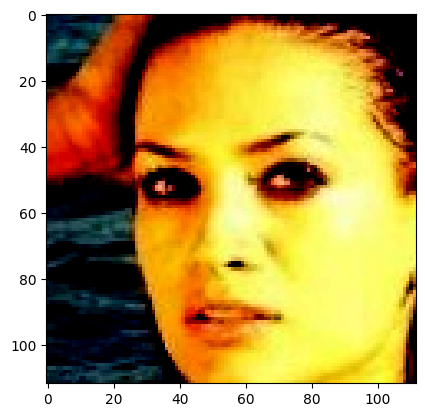

In [65]:
image_tensor_1, subject_1 = casia_train[500]
plt.imshow(image_tensor_1.numpy().transpose(1,2,0))
plt.show()

In [15]:
casia_dataloader_train = DataLoader(casia_train, batch_size=64, shuffle=True, drop_last=True, num_workers=16)
casia_dataloader_val = DataLoader(casia_val, batch_size=128, shuffle=False, drop_last=True)
casia_dataloader_test = DataLoader(casia_test, batch_size=128, shuffle=False, drop_last=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
nb_classes = casia_df['subject'].unique().shape[0]
print(nb_classes)

10572


In [16]:
#modifier la derniere couche du modèle pour avoir 10572 classes
# model.classifier = nn.Sequential(
#     nn.Flatten(start_dim=1, end_dim=-1),
#     nn.Linear(in_features=512, out_features=nb_classes, bias=True)             
# )
model = resnet18(pretrained=False, num_classes=nb_classes).cuda()

In [12]:
def accuracy_fn(logits, labels):
    y_probs=F.softmax(logits, dim=-1)
    y_preds=y_probs.argmax(dim=-1)
    accuracy=(y_preds==labels).sum()/len(labels)
    return accuracy

In [17]:
model.to(device)
#boucle d'entrainement
optimizer = Adam(params = model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)

nb_epochs=100
accuracies_g=[]
train_losses_g=[]
val_losses_g=[]
best_validation=1e9

for epoch in range(nb_epochs):
    accuracies=[]
    train_losses=[]
    val_losses=[]
    
    model.train()
    for batch, labels in tqdm(casia_dataloader_train):
        batch=batch.to(device)
        labels=labels.to(device)
        logits = model(batch)
        loss = loss_fn(logits, labels)
        optimizer.zero_grad() #mettre à zero les gradients
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(casia_dataloader_val):
            batch=batch.to(device)
            labels=labels.to(device)
            logits = model(batch)
            loss=loss_fn(logits, labels)
            accuracy=accuracy_fn(logits, labels)
            accuracies.append(accuracy.item())
            val_losses.append(loss.item())
            
    accuracies_g.append(torch.tensor(accuracies).mean().item())
    train_losses_g.append(torch.tensor(train_losses).mean().item())
    val_losses_g.append(torch.tensor(val_losses).mean().item())
    print(f"Epoch: {epoch}, train_loss: {train_losses_g[-1]}, val_loss: {val_losses_g[-1]}, accuracy: {accuracies_g[-1]}")
    if best_validation>val_losses_g[-1]:
        torch.save(model.state_dict(), '/kaggle/working/model.pt')
        best_validation=val_losses_g[-1]
    #sil ya cinq loss sans amélioration de la validation, on arrete
    if len(val_losses_g)>4 and (np.array(val_losses_g[-3:]).min() > train_losses_g[-4]):
        break
    torch.save({'val_loss': val_losses_g,
               'train_loss': train_losses_g,
               'accuracy': accuracies_g}, '/kaggle/working/train_stats.pt')


  0%|          | 0/6206 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# loaded_metrics = torch.load('/kaggle/working/train_stats.pt')
# loaded_metrics